In [28]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
)
from skimage.transform import resize

In [29]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep

images = []
directories = []
dircount = []
prevRoot = ''
cant = 0

print("Leyendo imágenes de", imgpath)

# Leer imágenes y redimensionar a 28x28
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant += 1
            filepath = os.path.join(root, filename)
            try:
                image = plt.imread(filepath)
                # CORRECCIÓN: Redimensionar todas las imágenes a 28x28
                image_resized = resize(image, (28, 28), anti_aliasing=True, 
                                      clip=False, preserve_range=True)
                # Asegurar que tenga 3 canales
                if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
                    images.append(image_resized)
                elif len(image_resized.shape) == 2:
                    # Convertir imágenes en escala de grises a RGB
                    image_rgb = np.stack([image_resized]*3, axis=-1)
                    images.append(image_rgb)
            except Exception as e:
                print(f"Error al leer {filepath}: {e}")
                cant -= 1
                continue
                
            if prevRoot != root:
                prevRoot = root
                directories.append(root)
                dircount.append(cant)
                cant = 0

dircount.append(cant)
dircount = dircount[1:]
dircount[0] = dircount[0] + 1

print('Directorios leídos:', len(directories))
print("Imágenes en cada directorio:", dircount)
print('Total de imágenes:', sum(dircount))

Leyendo imágenes de D:\PedroCarpetas\Tecnologico\Semestre 10\IA\Inteligencia-Artificial\sportimages\
Directorios leídos: 10
Imágenes en cada directorio: [9348, 8823, 7752, 7125, 7533, 5053, 7617, 9768, 5172, 8936]
Total de imágenes: 77127


In [30]:
labels = []
indice = 0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice += 1

print("Cantidad de etiquetas creadas:", len(labels))

# Obtener nombres de deportes
deportes = []
indice = 0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice, name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice += 1

Cantidad de etiquetas creadas: 77127
0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [31]:
y = np.array(labels)
X = np.array(images, dtype=np.float32)  # Convertir directamente a float32

classes = np.unique(y)
nClasses = len(classes)
print('Total de clases:', nClasses)
print('Clases:', classes)

# Normalizar imágenes
X = X / 255.0

print("Forma de X:", X.shape)
print("Valores min/max de X:", X.min(), X.max())

Total de clases: 10
Clases: [0 1 2 3 4 5 6 7 8 9]
Forma de X: (77127, 28, 28, 3)
Valores min/max de X: 0.0 1.0


In [32]:
# Primera división: train/test
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42)
print('Datos de entrenamiento:', train_X.shape, train_Y.shape)
print('Datos de prueba:', test_X.shape, test_Y.shape)

# Convertir etiquetas a one-hot encoding
train_Y_one_hot = to_categorical(train_Y, nClasses)
test_Y_one_hot = to_categorical(test_Y, nClasses)

print('Etiqueta original:', train_Y[0])
print('Después de one-hot:', train_Y_one_hot[0])

# Segunda división: train/validation
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X, train_Y_one_hot, test_size=0.2, random_state=13
)

print('Forma final de datos:')
print('Train:', train_X.shape, train_label.shape)
print('Valid:', valid_X.shape, valid_label.shape)
print('Test:', test_X.shape, test_Y_one_hot.shape)

Datos de entrenamiento: (61701, 28, 28, 3) (61701,)
Datos de prueba: (15426, 28, 28, 3) (15426,)
Etiqueta original: 8
Después de one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Forma final de datos:
Train: (49360, 28, 28, 3) (49360, 10)
Valid: (12341, 28, 28, 3) (12341, 10)
Test: (15426, 28, 28, 3) (15426, 10)


In [33]:
def create_model(input_shape, num_classes):
    """Crear modelo CNN mejorado"""
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, kernel_size=(3, 3), activation='linear', 
               padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.25),
        
        # Segunda capa convolucional
        Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.25),
        
        # Capas densas
        Flatten(),
        Dense(128, activation='linear'),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Crear el modelo
input_shape = (28, 28, 3)
deportes_model = create_model(input_shape, nClasses)

deportes_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                      

In [34]:
# Parámetros de entrenamiento
INIT_LR = 1e-3
epochs = 40
batch_size = 64

# Compilar el modelo (SIN .legacy)
optimizer = tf.keras.optimizers.legacy.SGD(
    learning_rate=INIT_LR,
    momentum=0.9,
    decay=INIT_LR / epochs
)

deportes_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks para mejorar el entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Entrenar el modelo
print("\n" + "="*50)
print("INICIANDO ENTRENAMIENTO")
print("="*50 + "\n")

history = deportes_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=callbacks
)


INICIANDO ENTRENAMIENTO

Epoch 1/40
772/772 [==============================] - 13s 17ms/step - loss: 1.7692 - accuracy: 0.3736 - val_loss: 1.0435 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 2/40
772/772 [==============================] - 13s 16ms/step - loss: 0.9766 - accuracy: 0.6810 - val_loss: 0.6622 - val_accuracy: 0.8039 - lr: 0.0010
Epoch 3/40
772/772 [==============================] - 13s 17ms/step - loss: 0.7208 - accuracy: 0.7685 - val_loss: 0.5098 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 4/40
772/772 [==============================] - 13s 17ms/step - loss: 0.6024 - accuracy: 0.8072 - val_loss: 0.4127 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 5/40
772/772 [==============================] - 13s 17ms/step - loss: 0.5166 - accuracy: 0.8365 - val_loss: 0.3478 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 6/40
772/772 [==============================] - 13s 17ms/step - loss: 0.4475 - accuracy: 0.8563 - val_loss: 0.2903 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 7/40
772/772 [============

In [35]:
model_path = "deportes_model_V3.h5"
deportes_model.save(model_path)
print(f"\nModelo guardado en: {model_path}")


D:\PedroCarpetas\Tecnologico\Semestre 10\IA\Inteligencia-Artificial\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Modelo guardado en: deportes_model_V3.h5


In [36]:
print("\n" + "="*50)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*50 + "\n")

test_eval = deportes_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('\nPérdida en test:', test_eval[0])
print('Precisión en test:', test_eval[1])


EVALUACIÓN EN CONJUNTO DE PRUEBA

483/483 [==============================] - 2s 4ms/step - loss: 0.0368 - accuracy: 0.9896

Pérdida en test: 0.036849286407232285
Precisión en test: 0.9896278977394104


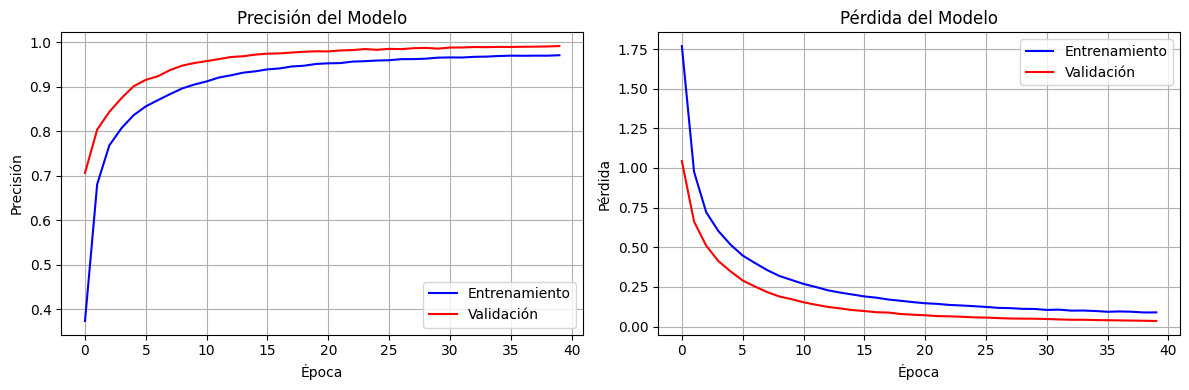

In [37]:
# Gráficas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Precisión
ax1.plot(history.history['accuracy'], 'b-', label='Entrenamiento')
ax1.plot(history.history['val_accuracy'], 'r-', label='Validación')
ax1.set_title('Precisión del Modelo')
ax1.set_xlabel('Época')
ax1.set_ylabel('Precisión')
ax1.legend()
ax1.grid(True)

# Pérdida
ax2.plot(history.history['loss'], 'b-', label='Entrenamiento')
ax2.plot(history.history['val_loss'], 'r-', label='Validación')
ax2.set_title('Pérdida del Modelo')
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

483/483 [==============================] - 2s 3ms/step

REPORTE DE CLASIFICACIÓN

                     precision    recall  f1-score   support

americano (Clase 0)       0.98      0.96      0.97      1887
   basket (Clase 1)       0.99      0.99      0.99      1712
 beisball (Clase 2)       0.98      0.99      0.99      1501
    boxeo (Clase 3)       1.00      1.00      1.00      1475
 ciclismo (Clase 4)       1.00      1.00      1.00      1576
       f1 (Clase 5)       0.98      0.98      0.98      1006
   futbol (Clase 6)       1.00      0.99      0.99      1512
     golf (Clase 7)       0.98      0.99      0.98      1919
 natacion (Clase 8)       1.00      1.00      1.00      1009
    tenis (Clase 9)       1.00      1.00      1.00      1829

           accuracy                           0.99     15426
          macro avg       0.99      0.99      0.99     15426
       weighted avg       0.99      0.99      0.99     15426


Encontradas 15266 predicciones correctas


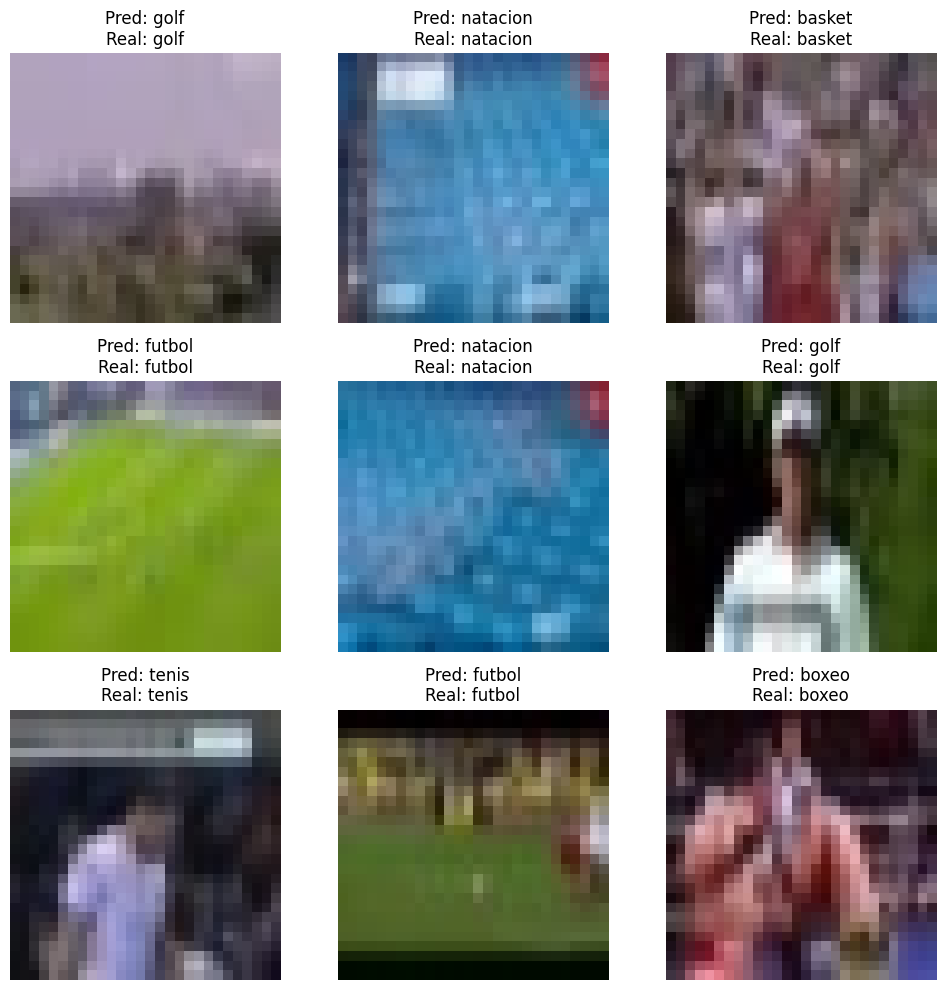


Encontradas 160 predicciones incorrectas


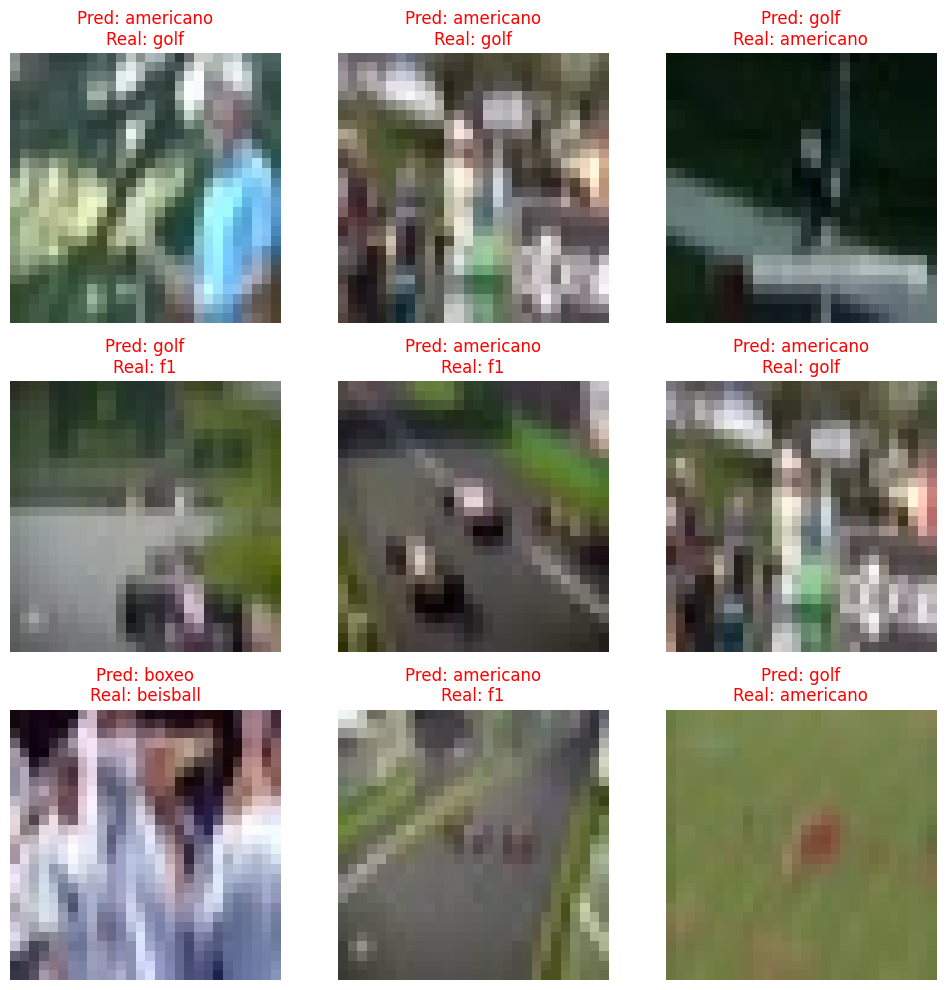

In [38]:
predicted_probs = deportes_model.predict(test_X)
predicted_classes = np.argmax(predicted_probs, axis=1)

print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50 + "\n")

target_names = [f"{deportes[i]} (Clase {i})" for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, 
                           target_names=target_names))

# Visualizar predicciones correctas
correct = np.where(predicted_classes == test_Y)[0]
print(f"\nEncontradas {len(correct)} predicciones correctas")

if len(correct) >= 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(correct[:9]):
        ax = axes[i // 3, i % 3]
        ax.imshow(test_X[idx])
        ax.set_title(f"Pred: {deportes[predicted_classes[idx]]}\n"
                    f"Real: {deportes[test_Y[idx]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('correct_predictions.png')
    plt.show()

# Visualizar predicciones incorrectas
incorrect = np.where(predicted_classes != test_Y)[0]
print(f"\nEncontradas {len(incorrect)} predicciones incorrectas")

if len(incorrect) >= 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(incorrect[:9]):
        ax = axes[i // 3, i % 3]
        ax.imshow(test_X[idx])
        ax.set_title(f"Pred: {deportes[predicted_classes[idx]]}\n"
                    f"Real: {deportes[test_Y[idx]]}", color='red')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png')
    plt.show()

In [39]:
def predecir_imagen(filepath, model, deportes):
    """
    Predecir el deporte en una imagen nueva
    
    Args:
        filepath: ruta al archivo de imagen
        model: modelo entrenado
        deportes: lista de nombres de deportes
    
    Returns:
        nombre del deporte predicho y probabilidad
    """
    try:
        # Leer y procesar imagen
        image = plt.imread(filepath)
        image_resized = resize(image, (28, 28), anti_aliasing=True,
                             clip=False, preserve_range=True)
        
        # Asegurar 3 canales
        if len(image_resized.shape) == 2:
            image_resized = np.stack([image_resized]*3, axis=-1)
        
        # Normalizar y agregar dimensión de batch
        image_norm = image_resized.astype('float32') / 255.0
        image_batch = np.expand_dims(image_norm, axis=0)
        
        # Predecir
        prediction = model.predict(image_batch, verbose=0)
        class_idx = np.argmax(prediction[0])
        confidence = prediction[0][class_idx]
        
        return deportes[class_idx], confidence
        
    except Exception as e:
        print(f"Error al procesar {filepath}: {e}")
        return None, 0.0

# Ejemplo de uso
print("\n" + "="*50)
print("EJEMPLO DE PREDICCIÓN")
print("="*50 + "\n")


EJEMPLO DE PREDICCIÓN



In [40]:
# Descomentar para probar con una imagen
deporte, confianza = predecir_imagen('Test.jpg', deportes_model, deportes)
if deporte:
    print(f"Deporte predicho: {deporte}")
    print(f"Confianza: {confianza:.2%}")

print("\n¡Entrenamiento completado exitosamente!")
print(f"Modelo guardado en: {model_path}")

Deporte predicho: americano
Confianza: 73.02%

¡Entrenamiento completado exitosamente!
Modelo guardado en: deportes_model_V3.h5
